# فرزانه کوهستانی
# 40115824

# Stock Market Prediction

#### This notebook aims at showing a short script on how to predict stock prices using a LSTM model. 

**Reminder:**

A Time Series is a time-indexed series of data. In Finance, a time series tracks the movement of the chosen data points, such as a security’s price, over a specified period of time with data points recorded at regular intervals.



## 1.Import libraries

In [9]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import matplotlib.pyplot as plt

<div dir=rtl>

در سلول بالا کتابخانه ها و ماژولهای موردنیاز اضافه شده اند.

</div>

## 2.Load data

In [11]:
def get_stock_data(company, start_date, end_date):

    df = yf.download(company, start_date, end_date)
    stock_data = df['Adj Close']
    return stock_data, df

<div dir=rtl>

با استفاده از تابع بالا به کمک کتابخانه yfinance با دریافت اسم کمپانی و تاریخ شروع و پایان سری زمانی، دیتاست مربوطه دانلود میشود.

سپس مقادیر هدف از دیتاست انتخاب شده و به همراه کل دیتاست بازگرندانده میشود.

</div>

In [12]:
start_date = "2010-01-01"
end_date = "2020-01-01"
# company = 'AAPl'
company = "GOOG"
stock_data, df = get_stock_data(company, start_date, end_date)

[*********************100%***********************]  1 of 1 completed


<div dir=rtl>

از تابعی که در سلول قبلی شرح دادیم استفاده شده است و داده های سری زمانی کمپانی GOOG را بین دو تاریخ گفته شده دریافت کرده است.

</div>

In [13]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,15.615220,15.678981,15.547723,15.610239,15.610239,78541293
2010-01-05,15.620949,15.637387,15.480475,15.541497,15.541497,120638494
2010-01-06,15.588072,15.588072,15.102393,15.149715,15.149715,159744526
2010-01-07,15.178109,15.193053,14.760922,14.797037,14.797037,257533695
2010-01-08,14.744733,15.024933,14.672753,14.994298,14.994298,189680313
...,...,...,...,...,...,...
2019-12-24,67.425003,67.513000,67.139000,67.178001,67.178001,6950000
2019-12-26,67.308502,68.066353,67.223503,68.019997,68.019997,13350000
2019-12-27,68.149498,68.226501,67.465500,67.594498,67.594498,20768000


In [14]:
stock_data

Date
2010-01-04    15.610239
2010-01-05    15.541497
2010-01-06    15.149715
2010-01-07    14.797037
2010-01-08    14.994298
                ...    
2019-12-24    67.178001
2019-12-26    68.019997
2019-12-27    67.594498
2019-12-30    66.806999
2019-12-31    66.850998
Name: Adj Close, Length: 2516, dtype: float64

Text(0, 0.5, 'Prices ($)')

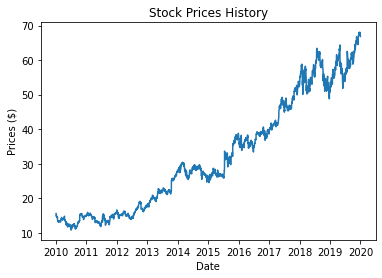

In [15]:
plt.title('Stock Prices History')
plt.plot(stock_data)
plt.xlabel('Date')
plt.ylabel('Prices ($)')

<div dir=rtl>

در نمودار بالا ارزش سهام این شرکت در طول زمان مشخص شده است.

</div>

## 3.Preprocessing

In [16]:
class DataProcessing:
    def __init__(self, data, percentage_of_training_data):
        self.stock_train = data[0: int(len(data) * percentage_of_training_data)]
        self.stock_test = data[int(len(data) * percentage_of_training_data): ]

    def gen_train(self, seq_len):
        """
        Generates training data
        :param seq_len: length of the days used for prediction
        :return: X_train and Y_train
        """
        input_train = []
        output_train = []

        for i in range(seq_len, len(self.stock_train)): 
            x = np.array(self.stock_train[i - seq_len: i])
            y = np.array([self.stock_train[i]], np.float64)
            input_train.append(x)
            output_train.append(y)

        input_train = np.array(input_train) / 200
        self.X_train = input_train.reshape((input_train.shape[0], input_train.shape[1], 1))
        self.Y_train = np.array(output_train) / 200
        
    def gen_test(self, seq_len):
        """
        Generates test data
        :param seq_len: Length of window
        :return: X_test and Y_test
        """
        input_test = []
        output_test = []

        for i in range(seq_len, len(self.stock_test)):  
            x = np.array(self.stock_test[i - seq_len: i])
            y = np.array([self.stock_test[i]], np.float64)
            input_test.append(x)
            output_test.append(y)
            
        input_test = np.array(input_test) / 200
        self.X_test = input_test.reshape((input_test.shape[0], input_test.shape[1], 1))
        self.Y_test = np.array(output_test) / 200


<div dir=rtl>

کلاس بالا از سه تابع تشکیل شده است،

در تابع __init__ با دریافت درصد جداسازی دادگان آموزش از تست، مجموعه داده ی دریافتی در آرگومان اول را به دو بخش متناسب با درصد دریافتی تقسیم بندی میکند.

سپس در تابع gen_test و gen_train با دریافت طول بازه سری زمانی مورد نیاز از مجموعه آموزش و تستی که در مرحله قبلی ساخته شده بود بازه هایی با همان طول میسازد و مجموعه های آموزش و تست را به بازه هایی با طول مشخص شده افراز میکند.




</div>

In [17]:
process = DataProcessing(stock_data, 0.8)
process.gen_test(30)
process.gen_train(30)

In [18]:
X_train = process.X_train
Y_train = process.Y_train 

X_test = process.X_test
Y_test = process.Y_test 

<div dir=rtl>

در دو سلول بالا، ابتدا مجموعه داده به نسبت 4 به 1 به دو بخش آموزش و تست تقسیم شده است و سپس سری زمانی هایی به طول سی روز از این دو مجموعه ساخته شده است.

</div>

# Super-Class

In [19]:
class RNN:
    def __init__(self, network_type, _input_shape, _dropout, _optimizer, _loss):
        if network_type == 'LSTM':
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.LSTM(units=50, return_sequences=True, input_shape=(_input_shape, 1)))
            model.add(tf.keras.layers.Dropout(_dropout))
            model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
            model.add(tf.keras.layers.Dropout(_dropout))
            model.add(tf.keras.layers.LSTM(units=50, return_sequences=True))
            model.add(tf.keras.layers.Dropout(_dropout))
            model.add(tf.keras.layers.LSTM(units=50))
            model.add(tf.keras.layers.Dropout(_dropout))
            model.add(tf.keras.layers.Dense(units=1))
            model.add(tf.keras.layers.Dropout(_dropout))
        elif network_type == 'GRU':
            model = tf.keras.Sequential()
            model.add(tf.keras.layers.GRU(units=50, return_sequences=True, input_shape=(_input_shape, 1), activation='tanh'))
            model.add(tf.keras.layers.Dropout(_dropout))
            model.add(tf.keras.layers.GRU(units=50, return_sequences=True, input_shape=(_input_shape, 1), activation='tanh'))
            model.add(tf.keras.layers.Dropout(_dropout))
            model.add(tf.keras.layers.GRU(units=50, return_sequences=True, input_shape=(_input_shape, 1), activation='tanh'))
            model.add(tf.keras.layers.Dropout(_dropout))
            model.add(tf.keras.layers.GRU(units=50, activation='tanh'))
            model.add(tf.keras.layers.Dropout(_dropout))
            model.add(tf.keras.layers.Dense(units=1))
        
        model.summary()
        model.compile(optimizer=_optimizer, loss=_loss)
        self.model = model
    
    def train(self, X_train, Y_train, EPOCHS):
        self.history = self.model.fit(X_train, Y_train, epochs=EPOCHS)
        plt.plot(self.history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()
    
    def evaluate(self, X_test, Y_test):
        print('\nEvaluate result:')
        self.model.evaluate(X_test, Y_test)
        
    def predict(self, X_test, Y_test):
        predicttion = self.model.predict(X_test)
        plt.plot(Y_test * 200, color='g', label=f'Actual {company} price')
        plt.plot(predicttion * 200, color='r', label=f'predicted {company} price')
        plt.title(f'{company} share price')
        plt.xlabel('time')
        plt.ylabel(f'{company} share price')
        plt.legend()

<div dir=rtl>

این کلاس به گونه ای طراحی شده است که بتوان در آن،

* نوع شبکه یعنی LSTM یا GRU
* ابعاد ورودی
* میزان dropout
* تابع فعالسازی
* تابع loss

را مشخص کرد.

این موارد در تابع __init__ کلاس مشخص میشوند و مدل ساخته میشود.

در تابع train داده ی آموزشی و تعدا ایپاک آموزش دریافت میشود و مدل آموزش میبیند.

در تابع test داده ی زمان تست دریافت شده و عملکرد مدل روی داده ی مشاهده نشده بررسی میشود.

و نهایتا در تابع predict نمودار مقدار حقیقی و پیشبینی شده برای داده های تست رسم میشود.
</div>

## Build LSTM model

<div dir=rtl>

در این قسمت شبکه ی LSTM با مقدار dropout ،برابر با صفر
با تابع بهینه ساز adam و تابع MSE loss ساخته شده است.

</div>

In [20]:
model_LSTM = RNN('LSTM', X_train.shape[1], 0, 'adam', 'mean_squared_error')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 50)            10400     
                                                                 
 dropout (Dropout)           (None, 30, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_1 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_2 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                2

<div dir=rtl>

این شبکه با استفاده از داده های آموزش به اندازه ی 50 ایپاک آموزش دیده است.

</div>

Epoch 1/50
62/62 [==============================] - 16s 109ms/step - loss: 9.7444e-04
Epoch 2/50
62/62 [==============================] - 6s 100ms/step - loss: 3.8540e-05
Epoch 3/50
62/62 [==============================] - 4s 60ms/step - loss: 3.8501e-05
Epoch 4/50
62/62 [==============================] - 4s 59ms/step - loss: 3.9370e-05
Epoch 5/50
62/62 [==============================] - 4s 59ms/step - loss: 3.7045e-05
Epoch 6/50
62/62 [==============================] - 4s 59ms/step - loss: 3.8422e-05
Epoch 7/50
62/62 [==============================] - 4s 58ms/step - loss: 3.7669e-05
Epoch 8/50
62/62 [==============================] - 4s 59ms/step - loss: 3.6553e-05
Epoch 9/50
62/62 [==============================] - 4s 57ms/step - loss: 3.7460e-05
Epoch 10/50
62/62 [==============================] - 4s 65ms/step - loss: 3.7144e-05
Epoch 11/50
62/62 [==============================] - 6s 96ms/step - loss: 3.7226e-05
Epoch 12/50
62/62 [==============================] - 5s 84ms/step - los

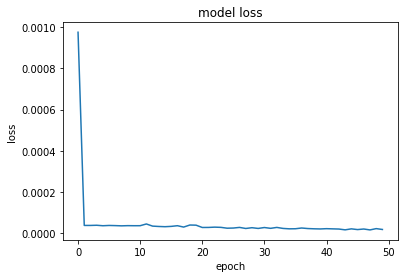

In [21]:
model_LSTM.train(X_train, Y_train, 50)

<div dir=rtl>

در این قسمت عملکرد مدل را بررسی کرده است و loss شبکه را به دست می آورد.

</div>

In [22]:
model_LSTM.evaluate(X_test, Y_test)


Evaluate result:
15/15 [==============================] - 2s 16ms/step - loss: 6.9478e-05



<div dir=rtl>

در سلول پایین نمودار مقدار حقیقی و مقدار پیشبینی شده را رسم میکند.

</div>

15/15 [==============================] - 2s 15ms/step


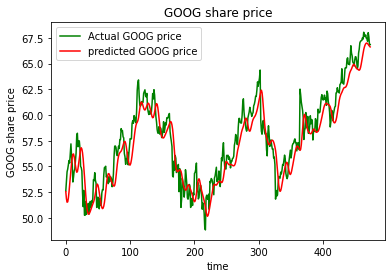

In [23]:
model_LSTM.predict(X_test, Y_test)

## Build GRU model

<div dir=rtl>

در این قسمت شبکه ی GRU با مقدار dropout ،برابر با صفر
با تابع بهینه ساز adam و تابع MSE loss ساخته شده است.

</div>

In [24]:
model_GRU = RNN('GRU', X_train.shape[1], 0, 'adam', 'mean_squared_error')

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 30, 50)            7950      
                                                                 
 dropout_5 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_1 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_6 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_2 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_7 (Dropout)         (None, 30, 50)            0         
                                                                 
 gru_3 (GRU)                 (None, 50)               

<div dir=rtl>

این شبکه با استفاده از داده های آموزش به اندازه ی 50 ایپاک آموزش دیده است.

</div>

Epoch 1/50
62/62 [==============================] - 20s 120ms/step - loss: 0.0015
Epoch 2/50
62/62 [==============================] - 4s 62ms/step - loss: 1.8107e-05
Epoch 3/50
62/62 [==============================] - 4s 59ms/step - loss: 1.5652e-05
Epoch 4/50
62/62 [==============================] - 4s 58ms/step - loss: 1.5111e-05
Epoch 5/50
62/62 [==============================] - 4s 58ms/step - loss: 1.8270e-05
Epoch 6/50
62/62 [==============================] - 4s 59ms/step - loss: 1.4803e-05
Epoch 7/50
62/62 [==============================] - 4s 59ms/step - loss: 1.3934e-05
Epoch 8/50
62/62 [==============================] - 4s 57ms/step - loss: 1.4741e-05
Epoch 9/50
62/62 [==============================] - 4s 58ms/step - loss: 1.4905e-05
Epoch 10/50
62/62 [==============================] - 4s 59ms/step - loss: 1.3459e-05
Epoch 11/50
62/62 [==============================] - 4s 58ms/step - loss: 1.6370e-05
Epoch 12/50
62/62 [==============================] - 4s 58ms/step - loss: 1.

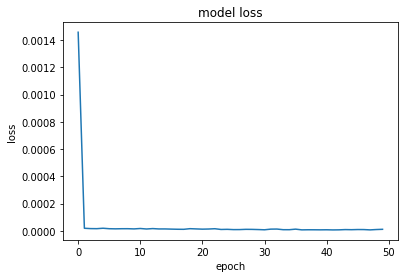

In [25]:
model_GRU.train(X_train, Y_train, 50)

<div dir=rtl>

در این قسمت عملکرد مدل را بررسی کرده است و loss شبکه را به دست می آورد.

</div>

In [26]:
model_GRU.evaluate(X_test, Y_test)


Evaluate result:
15/15 [==============================] - 2s 14ms/step - loss: 2.5115e-05



<div dir=rtl>

در سلول پایین نمودار مقدار حقیقی و مقدار پیشبینی شده را رسم میکند.

</div>

15/15 [==============================] - 2s 14ms/step


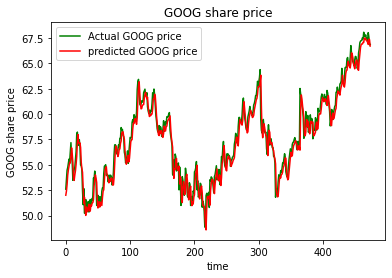

In [27]:
model_GRU.predict(X_test, Y_test)

## الف

<div dir=rtl>

در این قسمت دو مدل یکی بر پایه ی کامنپوننت های GRU و دیگری بر پایه ی کامپوننت های LSTM ساخته شدند.

هر دو مدل از تابع بهینه سازی Adam و MSE loss استفاده کردند.

پس از آموزش روی مجموعه داده ی آموزشی و بررسی عملکرد مدل روی داده های تست میبینیم مدل مبتنی بر GRU نسبت به مدل مبتنی بر LSTM مقدار loss کمتری در زمان آموزش دارد.

همچنین مقدار loss در زمان تست برای شبکه مبتنی بر GRU کمتر است از مقدار loss برای شبکه مبتنی بر LSTM.

با مشاهده نمودارهای مقدار حقیقی و مقدار پیشبینی شده هم درمیابیم که عملکرد مدل GRU به نسبت مدل LSTM بروی داده های تست، عملکرد بهتری بوده است.

* بهترین مدل تا این مرحله مدل GRU با بهینه ساز adam و MSE Loss است.

</div>

## Build LSTM model - RMSProp

<div dir=rtl>

در این قسمت شبکه ی LSTM با مقدار dropout ،برابر با صفر
با تابع بهینه ساز RMSProp و تابع MSE loss ساخته شده است.

</div>

In [28]:
model_LSTM_rmsprop = RNN('LSTM', X_train.shape[1], 0, 'rmsprop', 'mean_squared_error')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_9 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_10 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_11 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_7 (LSTM)               (None, 50)               

<div dir=rtl>

این شبکه با استفاده از داده های آموزش به اندازه ی 50 ایپاک آموزش دیده است.

</div>

Epoch 1/50
62/62 [==============================] - 11s 59ms/step - loss: 0.0015
Epoch 2/50
62/62 [==============================] - 4s 59ms/step - loss: 6.5037e-04
Epoch 3/50
62/62 [==============================] - 4s 58ms/step - loss: 4.2321e-04
Epoch 4/50
62/62 [==============================] - 4s 56ms/step - loss: 3.1889e-04
Epoch 5/50
62/62 [==============================] - 4s 60ms/step - loss: 2.5641e-04
Epoch 6/50
62/62 [==============================] - 4s 61ms/step - loss: 2.4505e-04
Epoch 7/50
62/62 [==============================] - 5s 84ms/step - loss: 2.1667e-04
Epoch 8/50
62/62 [==============================] - 4s 71ms/step - loss: 1.8785e-04
Epoch 9/50
62/62 [==============================] - 5s 83ms/step - loss: 1.7437e-04
Epoch 10/50
62/62 [==============================] - 4s 58ms/step - loss: 1.6297e-04
Epoch 11/50
62/62 [==============================] - 5s 75ms/step - loss: 1.5494e-04
Epoch 12/50
62/62 [==============================] - 4s 58ms/step - loss: 1.3

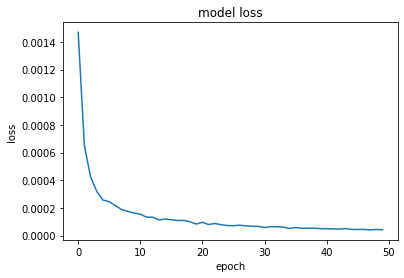

In [29]:
model_LSTM_rmsprop.train(X_train, Y_train, 50)

<div dir=rtl>

در این قسمت عملکرد مدل را بررسی کرده است و loss شبکه را به دست می آورد.

</div>

In [30]:
model_LSTM_rmsprop.evaluate(X_test, Y_test)


Evaluate result:
15/15 [==============================] - 2s 25ms/step - loss: 2.4960e-04



<div dir=rtl>

در سلول پایین نمودار مقدار حقیقی و مقدار پیشبینی شده را رسم میکند.

</div>

15/15 [==============================] - 2s 20ms/step


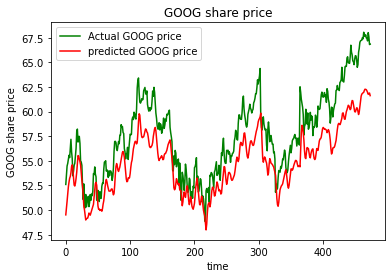

In [31]:
model_LSTM_rmsprop.predict(X_test, Y_test)

## Build GRU model - RMSProp

<div dir=rtl>

در این قسمت شبکه ی GRU با مقدار dropout ،برابر با صفر
با تابع بهینه ساز RMSProp و تابع MSE loss ساخته شده است.

</div>

In [32]:
model_GRU_rmsprop = RNN('GRU', X_train.shape[1], 0, 'rmsprop', 'mean_squared_error')

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 30, 50)            7950      
                                                                 
 dropout_14 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_5 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_15 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_6 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_16 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_7 (GRU)                 (None, 50)               

<div dir=rtl>

این شبکه با استفاده از داده های آموزش به اندازه ی 50 ایپاک آموزش دیده است.

</div>

Epoch 1/50
62/62 [==============================] - 14s 75ms/step - loss: 0.0013
Epoch 2/50
62/62 [==============================] - 5s 75ms/step - loss: 5.7352e-04
Epoch 3/50
62/62 [==============================] - 5s 75ms/step - loss: 4.6889e-04
Epoch 4/50
62/62 [==============================] - 5s 75ms/step - loss: 3.5479e-04
Epoch 5/50
62/62 [==============================] - 4s 71ms/step - loss: 3.1554e-04
Epoch 6/50
62/62 [==============================] - 4s 60ms/step - loss: 2.6940e-04
Epoch 7/50
62/62 [==============================] - 5s 76ms/step - loss: 2.1474e-04
Epoch 8/50
62/62 [==============================] - 6s 93ms/step - loss: 2.1176e-04
Epoch 9/50
62/62 [==============================] - 5s 77ms/step - loss: 1.8004e-04
Epoch 10/50
62/62 [==============================] - 4s 72ms/step - loss: 1.7293e-04
Epoch 11/50
62/62 [==============================] - 4s 59ms/step - loss: 1.5413e-04
Epoch 12/50
62/62 [==============================] - 4s 66ms/step - loss: 1.3

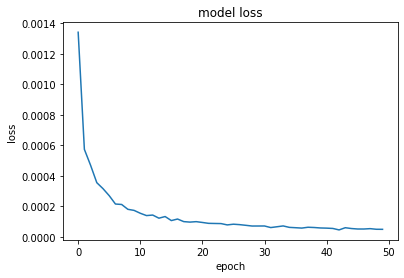

In [33]:
model_GRU_rmsprop.train(X_train, Y_train, 50)

<div dir=rtl>

در این قسمت عملکرد مدل را بررسی کرده است و loss شبکه را به دست می آورد.

</div>

In [34]:
model_GRU_rmsprop.evaluate(X_test, Y_test)


Evaluate result:
15/15 [==============================] - 3s 17ms/step - loss: 9.7852e-04



<div dir=rtl>

در سلول پایین نمودار مقدار حقیقی و مقدار پیشبینی شده را رسم میکند.

</div>

15/15 [==============================] - 3s 39ms/step


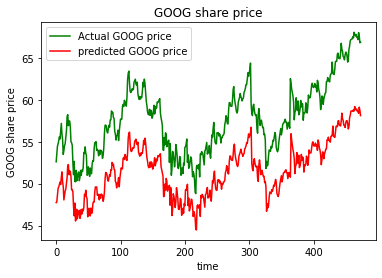

In [35]:
model_GRU_rmsprop.predict(X_test, Y_test)

## ب

<div dir=rtl>

### مدل مبتنی بر LSTM

با مقایسه ی مدل مبتنی بر LSTM که یکبار از تابع بهینه ساز Adam و بار دیگر از تابع بهینه ساز RMSProp استفاده کرده است متوجه میشویم استفاده از بهینه ساز Adam نتیجه بسیار بهتری داشته است و مقدار loss در زمان تست با بهینه ساز adam حدودا یک دهم مقدار loss در زمان تست با بهینه ساز rmsprop است.

### مدل مبتنی بر GRU

با مقایسه ی مدل مبتنی بر GRU که یکبار از تابع بهینه ساز Adam و بار دیگر از تابع بهینه ساز RMSProp استفاده کرده است متوجه میشویم استفاده از بهینه ساز Adam نتیجه بسیار بهتری داشته است و مقدار loss در زمان تست با بهینه ساز adam حدودا یک چهلم مقدار loss در زمان تست با بهینه ساز rmsprop است.

* بهترین مدل تا این مرحله مدل GRU با بهینه ساز adam و MSE Loss است.

</div>

## Build LSTM model - mean_absolute_percentage_error

<div dir=rtl>

در این قسمت شبکه ی LSTM با مقدار dropout ،برابر با صفر
با تابع بهینه ساز adam و تابع MAPE loss ساخته شده است.

</div>

In [36]:
model_LSTM_mape = RNN('LSTM', X_train.shape[1], 0, 'adam', 'mean_absolute_percentage_error')

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_18 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 50)            20200     
                                                                 
 dropout_19 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_10 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_20 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_11 (LSTM)              (None, 50)               

<div dir=rtl>

این شبکه با استفاده از داده های آموزش به اندازه ی 50 ایپاک آموزش دیده است.

</div>

Epoch 1/50
62/62 [==============================] - 11s 59ms/step - loss: 16.4808
Epoch 2/50
62/62 [==============================] - 4s 58ms/step - loss: 4.5664
Epoch 3/50
62/62 [==============================] - 4s 73ms/step - loss: 4.7514
Epoch 4/50
62/62 [==============================] - 5s 82ms/step - loss: 4.7312
Epoch 5/50
62/62 [==============================] - 5s 76ms/step - loss: 4.3806
Epoch 6/50
62/62 [==============================] - 5s 73ms/step - loss: 4.4673
Epoch 7/50
62/62 [==============================] - 5s 77ms/step - loss: 4.0372
Epoch 8/50
62/62 [==============================] - 5s 80ms/step - loss: 3.9792
Epoch 9/50
62/62 [==============================] - 5s 83ms/step - loss: 3.3771
Epoch 10/50
62/62 [==============================] - 5s 77ms/step - loss: 3.3040
Epoch 11/50
62/62 [==============================] - 4s 68ms/step - loss: 3.1784
Epoch 12/50
62/62 [==============================] - 5s 82ms/step - loss: 3.6518
Epoch 13/50
62/62 [================

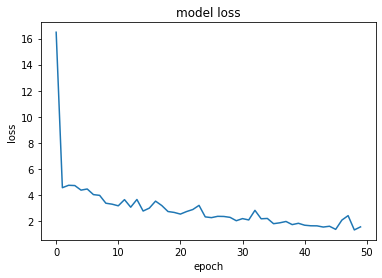

In [37]:
model_LSTM_mape.train(X_train, Y_train, 50)

<div dir=rtl>

در این قسمت عملکرد مدل را بررسی کرده است و loss شبکه را به دست می آورد.

</div>

In [38]:
model_LSTM_mape.evaluate(X_test, Y_test)


Evaluate result:
15/15 [==============================] - 3s 17ms/step - loss: 1.4447



<div dir=rtl>

در سلول پایین نمودار مقدار حقیقی و مقدار پیشبینی شده را رسم میکند.

</div>

15/15 [==============================] - 2s 16ms/step


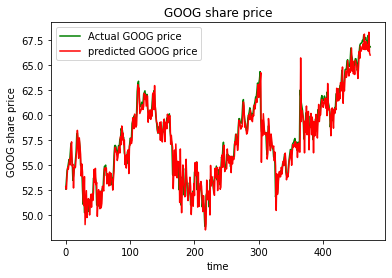

In [39]:
model_LSTM_mape.predict(X_test, Y_test)

## Build GRU model - mean_absolute_percentage_error

<div dir=rtl>

در این قسمت شبکه ی GRU با مقدار dropout ،برابر با صفر
با تابع بهینه ساز adam و تابع MAPE loss ساخته شده است.

</div>

In [40]:
model_GRU_mape = RNN('GRU', X_train.shape[1], 0, 'adam', 'mean_absolute_percentage_error')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_8 (GRU)                 (None, 30, 50)            7950      
                                                                 
 dropout_23 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_9 (GRU)                 (None, 30, 50)            15300     
                                                                 
 dropout_24 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_10 (GRU)                (None, 30, 50)            15300     
                                                                 
 dropout_25 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_11 (GRU)                (None, 50)               

<div dir=rtl>

این شبکه با استفاده از داده های آموزش به اندازه ی 50 ایپاک آموزش دیده است.

</div>

Epoch 1/50
62/62 [==============================] - 16s 82ms/step - loss: 13.0092
Epoch 2/50
62/62 [==============================] - 5s 84ms/step - loss: 2.7988
Epoch 3/50
62/62 [==============================] - 5s 74ms/step - loss: 3.0700
Epoch 4/50
62/62 [==============================] - 4s 59ms/step - loss: 3.2516
Epoch 5/50
62/62 [==============================] - 5s 85ms/step - loss: 3.3590
Epoch 6/50
62/62 [==============================] - 4s 63ms/step - loss: 3.2383
Epoch 7/50
62/62 [==============================] - 4s 58ms/step - loss: 2.5825
Epoch 8/50
62/62 [==============================] - 4s 60ms/step - loss: 2.8326
Epoch 9/50
62/62 [==============================] - 4s 69ms/step - loss: 4.4194
Epoch 10/50
62/62 [==============================] - 5s 74ms/step - loss: 3.5755
Epoch 11/50
62/62 [==============================] - 4s 59ms/step - loss: 1.8977
Epoch 12/50
62/62 [==============================] - 4s 60ms/step - loss: 2.1625
Epoch 13/50
62/62 [================

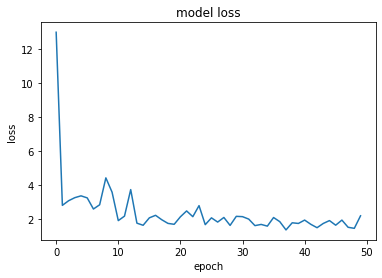

In [41]:
model_GRU_mape.train(X_train, Y_train, 50)

<div dir=rtl>

در این قسمت عملکرد مدل را بررسی کرده است و loss شبکه را به دست می آورد.

</div>

In [42]:
model_GRU_mape.evaluate(X_test, Y_test)


Evaluate result:
15/15 [==============================] - 2s 14ms/step - loss: 1.2744



<div dir=rtl>

در سلول پایین نمودار مقدار حقیقی و مقدار پیشبینی شده را رسم میکند.

</div>

15/15 [==============================] - 2s 15ms/step


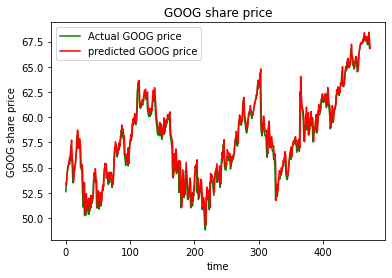

In [43]:
model_GRU_mape.predict(X_test, Y_test)

## ج

<div dir=rtl>

در این قسمت دو مدل مبتنی بر GRU و LSTM را با استفاده از بهینه ساز adam و MAPE loss آموزش داده ایم.

اینبار مشابه قسمت های قبل نمیتوانیم از مقایسه ی مقدار loss برای مقایسه ی عملکرد دو مدل استفاده کنیم چرا که از توابع گوناگونی استفاده کرده ایم، اما از روی نمودار مقدار حقیقی و مقدار پیش بینی شده میتوانیم مدل ها را مقایسه کنیم.

بصورت کلی در این قسمت نیز مدل مبتنی بر GRU عملکرد بهتری نسبت به مدل مبتنی بر LSTM داشته است.

حال اگر بهترین مدل تا کنون را با مدل مبتنی بر GRU اسن قسمت مقایسه کنیم میبینیم عملکرد مدلی که با تابع MSE loss ساخته شده است بهتر است چرا که بین سمپلهای متوالی نوسانات کمتری دارد.

* بهترین مدل تا این مرحله مدل GRU با بهینه ساز adam و MSE Loss است.


</div>

## Build LSTM model - Dropout

<div dir=rtl>

در این قسمت شبکه ی LSTM با مقدار dropout ،برابر با 0.2
با تابع بهینه ساز adam و تابع MSE loss ساخته شده است.

</div>

In [44]:
model_LSTM_dropout = RNN('LSTM', X_train.shape[1], 0.2, 'adam', 'mean_absolute_error')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 30, 50)            10400     
                                                                 
 dropout_27 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_13 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_28 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_14 (LSTM)              (None, 30, 50)            20200     
                                                                 
 dropout_29 (Dropout)        (None, 30, 50)            0         
                                                                 
 lstm_15 (LSTM)              (None, 50)               

<div dir=rtl>

این شبکه با استفاده از داده های آموزش به اندازه ی 50 ایپاک آموزش دیده است.

</div>

Epoch 1/50
62/62 [==============================] - 13s 69ms/step - loss: 0.0457
Epoch 2/50
62/62 [==============================] - 5s 80ms/step - loss: 0.0372
Epoch 3/50
62/62 [==============================] - 5s 81ms/step - loss: 0.0348
Epoch 4/50
62/62 [==============================] - 5s 74ms/step - loss: 0.0351
Epoch 5/50
62/62 [==============================] - 5s 75ms/step - loss: 0.0342
Epoch 6/50
62/62 [==============================] - 5s 80ms/step - loss: 0.0330
Epoch 7/50
62/62 [==============================] - 5s 76ms/step - loss: 0.0340
Epoch 8/50
62/62 [==============================] - 5s 80ms/step - loss: 0.0327
Epoch 9/50
62/62 [==============================] - 5s 85ms/step - loss: 0.0303
Epoch 10/50
62/62 [==============================] - 5s 77ms/step - loss: 0.0312
Epoch 11/50
62/62 [==============================] - 4s 67ms/step - loss: 0.0325
Epoch 12/50
62/62 [==============================] - 4s 61ms/step - loss: 0.0316
Epoch 13/50
62/62 [=================

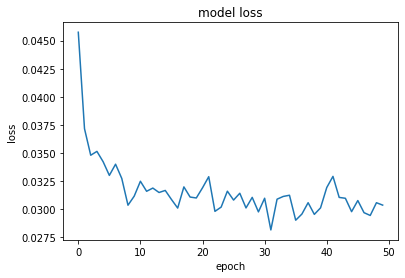

In [45]:
model_LSTM_dropout.train(X_train, Y_train, 50)

<div dir=rtl>

در این قسمت عملکرد مدل را بررسی کرده است و loss شبکه را به دست می آورد.

</div>

In [46]:
model_LSTM_dropout.evaluate(X_test, Y_test)


Evaluate result:
15/15 [==============================] - 3s 27ms/step - loss: 0.0582



<div dir=rtl>

در سلول پایین نمودار مقدار حقیقی و مقدار پیشبینی شده را رسم میکند.

</div>

15/15 [==============================] - 2s 16ms/step


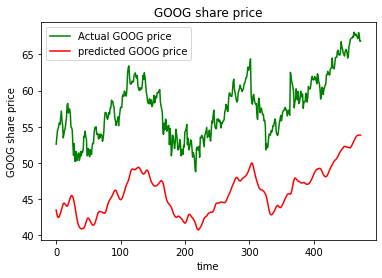

In [47]:
model_LSTM_dropout.predict(X_test, Y_test)

## Build GRU model - Dropout

<div dir=rtl>

در این قسمت شبکه ی GRU با مقدار dropout ،برابر با 0.2
با تابع بهینه ساز adam و تابع MSE loss ساخته شده است.

</div>

In [48]:
model_GRU_dropout = RNN('GRU', X_train.shape[1], 0.2, 'adam', 'mean_absolute_error')

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_12 (GRU)                (None, 30, 50)            7950      
                                                                 
 dropout_32 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_13 (GRU)                (None, 30, 50)            15300     
                                                                 
 dropout_33 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_14 (GRU)                (None, 30, 50)            15300     
                                                                 
 dropout_34 (Dropout)        (None, 30, 50)            0         
                                                                 
 gru_15 (GRU)                (None, 50)               

<div dir=rtl>

این شبکه با استفاده از داده های آموزش به اندازه ی 50 ایپاک آموزش دیده است.

</div>

Epoch 1/50
62/62 [==============================] - 13s 60ms/step - loss: 0.0253
Epoch 2/50
62/62 [==============================] - 4s 60ms/step - loss: 0.0105
Epoch 3/50
62/62 [==============================] - 4s 61ms/step - loss: 0.0102
Epoch 4/50
62/62 [==============================] - 4s 63ms/step - loss: 0.0089
Epoch 5/50
62/62 [==============================] - 4s 60ms/step - loss: 0.0080
Epoch 6/50
62/62 [==============================] - 4s 60ms/step - loss: 0.0088
Epoch 7/50
62/62 [==============================] - 5s 80ms/step - loss: 0.0083
Epoch 8/50
62/62 [==============================] - 4s 60ms/step - loss: 0.0076
Epoch 9/50
62/62 [==============================] - 4s 60ms/step - loss: 0.0082
Epoch 10/50
62/62 [==============================] - 4s 61ms/step - loss: 0.0070
Epoch 11/50
62/62 [==============================] - 4s 61ms/step - loss: 0.0074
Epoch 12/50
62/62 [==============================] - 4s 61ms/step - loss: 0.0074
Epoch 13/50
62/62 [=================

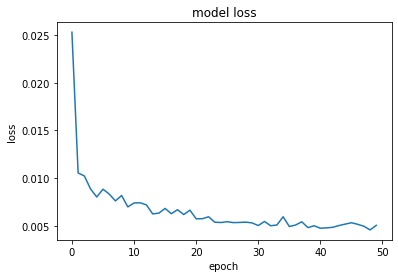

In [49]:
model_GRU_dropout.train(X_train, Y_train, 50)

<div dir=rtl>

در این قسمت عملکرد مدل را بررسی کرده است و loss شبکه را به دست می آورد.

</div>

In [50]:
model_GRU_dropout.evaluate(X_test, Y_test)


Evaluate result:
15/15 [==============================] - 2s 16ms/step - loss: 0.0098



<div dir=rtl>

در سلول پایین نمودار مقدار حقیقی و مقدار پیشبینی شده را رسم میکند.

</div>

15/15 [==============================] - 2s 17ms/step


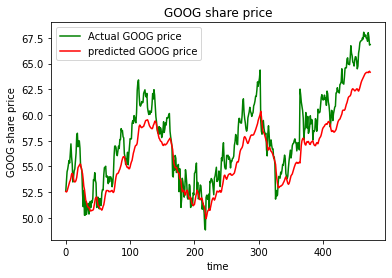

In [51]:
model_GRU_dropout.predict(X_test, Y_test)

## د

<div dir=rtl>

در این قسمت دو مدل مبتنی بر GRU و LSTM که از تابع فعالساز adam و MSE loss استفاده میکردند را با dropout 0.2 آموزش داده ایم.

مشاهده میشود عملکرد هر دو مدل بعد از استفاده از dropout بسیار افت میکند.

این اتفاق خلاف انتظار ما نیست، چرا که مدلهای بدون dropout دچار overfiting نبودند و علاوه بر زمان آموزش در زمان تست نیز عملکرد بسیار خوبی بر روی داده های مشاهده نشده اند و صرفا استفاده کردن dropout باعث شده عملکرد خوب مدل از بین ببرد.

.

* نهایتا مدل مبتنی بر شبکه GRU که با استفاده از تابع adam بهینه شده و از MSE loss استفاده کرده است بعنوان بهترین مدل انتخاب میشود.


</div>

## Best model evaluation

In [60]:
start_date = "2020-01-01"
end_date = "2021-01-01"
company = 'GOOG'
def back_test(model, seq_len, company, start_date, end_date):
    stock_data, df = get_stock_data(company, start_date, end_date)
    process = DataProcessing(stock_data, 0)
    process.gen_test(seq_len)
    X_test = process.X_test
    Y_test = process.Y_test
    model.predict(X_test, Y_test)

[*********************100%***********************]  1 of 1 completed
7/7 [==============================] - 0s 15ms/step


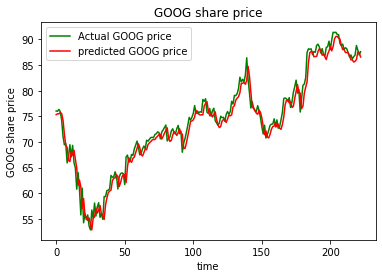

In [61]:
back_test(model_GRU, 30, company, start_date, end_date)

<div dir=rtl>

در این قسمت قصد داریم عملکرد مدلمان را روی داده های دیده نشده و اخیر شرکت گوگل بررسی کنیم. طول سری زمانی برابر با 30 روز است و بازه زمانی از اولین روز سال 2020 تا اولین روز سال 2022 انتخاب شده است.

داده های این بازه زمانی را با استفاده از کتابخانه yfinance دریافت میکنیم،

همه ی آنها را بعنوان داده ی تست جداسازی میکنیم،

و از آنها سری زمانی به طول 30 روز میسازیم.

این داده ها را به بهترین مدلمان میدهیم و برای آن نمودار مقایسه مقدار حقیقی و مقدار پیشبینی شده را رسم میکنیم.

با بررسی نمودار درمیابیم مدل با موفقیت و با مقدار بسیار کمی اختلاف توانسته ارزش سهام این شرکت را تخمین بزند.

</div>